In [1]:
import os
from os.path import join as pj
import argparse
import sys
sys.path.append("modules")
import utils
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn.mixture import GaussianMixture
import seaborn as sns
from joblib import Parallel, delayed
import rpy2.robjects as robjects
import umap
import re
import matplotlib.pyplot as plt
from sklearn import metrics
import scanpy as sc
import pandas as pd
import csv

2024-01-08 12:07:25.023609: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--task', type=str, default='single_spleen_cl')
parser.add_argument('--reference', type=str, default='atlas_new')
parser.add_argument('--experiment', type=str, default='c_1')
parser.add_argument('--model', type=str, default='default')
parser.add_argument('--init_model', type=str, default='')
parser.add_argument('--init_model_ref', type=str, default='sp_latest')
parser.add_argument('--method', type=str, default='midas_embed')
o, _ = parser.parse_known_args()  # for python interactive
# o = parser.parse_args()

# Load data and labels

In [3]:
# load latent variables
data_config = utils.gen_data_config(o.task)
data_config_ref = utils.gen_data_config(o.reference)
data_config_ref["raw_data_dirs"] += data_config["raw_data_dirs"]
data_config_ref["raw_data_frags"] += data_config["raw_data_frags"]
data_config_ref["combs"] = data_config["combs"]
data_config_ref["comb_ratios"] = data_config["comb_ratios"]
data_config_ref["s_joint"] = data_config["s_joint"]
for k, v in data_config_ref.items():
    vars(o)[k] = v
model_config = utils.load_toml("configs/model.toml")["default"]
if o.model != "default":
    model_config.update(utils.load_toml("configs/model.toml")[o.model])
for k, v in model_config.items():
    vars(o)[k] = v
o.s_joint, o.combs, *_ = utils.gen_all_batch_ids(o.s_joint, o.combs)

o.pred_dir = pj("result", o.task, o.experiment, o.model, "predict", o.init_model)
pred = utils.load_predicted(o, group_by="subset")

c = [v["z"]["joint"][:, :o.dim_c] for v in pred.values()]
subset_num = 34
c_ref = np.concatenate(c[:subset_num], axis=0)
c_query = np.concatenate(c[subset_num:], axis=0)
c_all = np.concatenate([c_query, c_ref], axis=0)

  0%|          | 0/24 [00:00<?, ?it/s]

Loading predicted variables ...
Loading subset 0: z, joint
Loading subset 1: z, joint


 42%|████▎     | 17/40 [00:00<00:00, 158.02it/s]

Loading subset 2: z, joint


  0%|          | 0/29 [00:00<?, ?it/s]

Loading subset 3: z, joint
Loading subset 4: z, joint


  0%|          | 0/27 [00:00<?, ?it/s]

Loading subset 5: z, joint
Loading subset 6: z, joint


  0%|          | 0/28 [00:00<?, ?it/s]

Loading subset 7: z, joint
Loading subset 8: z, joint


  0%|          | 0/29 [00:00<?, ?it/s]

Loading subset 9: z, joint
Loading subset 10: z, joint


  0%|          | 0/38 [00:00<?, ?it/s]

Loading subset 11: z, joint
Loading subset 12: z, joint


 68%|██████▊   | 30/44 [00:00<00:00, 291.96it/s]

Loading subset 13: z, joint


  0%|          | 0/20 [00:00<?, ?it/s]

Loading subset 14: z, joint
Loading subset 15: z, joint
Loading subset 16: z, joint
Loading subset 17: z, joint


  0%|          | 0/24 [00:00<?, ?it/s]

Loading subset 18: z, joint
Loading subset 19: z, joint
Loading subset 20: z, joint


  0%|          | 0/28 [00:00<?, ?it/s]

Loading subset 21: z, joint
Loading subset 22: z, joint
Loading subset 23: z, joint


 74%|███████▍  | 26/35 [00:00<00:00, 253.46it/s]

Loading subset 24: z, joint
Loading subset 25: z, joint


  0%|          | 0/22 [00:00<?, ?it/s]

Loading subset 26: z, joint
Loading subset 27: z, joint


  0%|          | 0/47 [00:00<?, ?it/s]

Loading subset 28: z, joint
Loading subset 29: z, joint


 38%|███▊      | 22/58 [00:00<00:00, 204.50it/s]

Loading subset 30: z, joint


  0%|          | 0/52 [00:00<?, ?it/s]

Loading subset 31: z, joint
Loading subset 32: z, joint


  0%|          | 0/17 [00:00<?, ?it/s]

Loading subset 33: z, joint
Loading subset 34: z, joint


100%|██████████| 17/17 [00:00<00:00, 17.21it/s]


Converting to numpy ...
Converting subset 0: s, joint
Converting subset 0: z, joint
Converting subset 1: s, joint
Converting subset 1: z, joint
Converting subset 2: s, joint
Converting subset 2: z, joint
Converting subset 3: s, joint
Converting subset 3: z, joint
Converting subset 4: s, joint
Converting subset 4: z, joint
Converting subset 5: s, joint
Converting subset 5: z, joint
Converting subset 6: s, joint
Converting subset 6: z, joint
Converting subset 7: s, joint
Converting subset 7: z, joint
Converting subset 8: s, joint
Converting subset 8: z, joint
Converting subset 9: s, joint
Converting subset 9: z, joint
Converting subset 10: s, joint
Converting subset 10: z, joint
Converting subset 11: s, joint
Converting subset 11: z, joint
Converting subset 12: s, joint
Converting subset 12: z, joint
Converting subset 13: s, joint
Converting subset 13: z, joint
Converting subset 14: s, joint
Converting subset 14: z, joint
Converting subset 15: s, joint
Converting subset 15: z, joint
Conv

In [4]:
c_all = umap.UMAP(n_neighbors=30, metric="cosine", min_dist=0.3, random_state=42).fit_transform(c_all)
c_query = c_all[:len(c_query), :]
c_ref = c_all[len(c_query):, :]

In [5]:
# load training labels
label_ref = np.array(utils.transpose_list(utils.load_csv(pj("analysis", "atlas_label", "atlas_new.csv")))[1][1:])
label_query = np.array(["query"]*c_query.shape[0])
label_train = np.concatenate([label_query, label_ref])
# print("label_train: ", np.unique(label_train))

In [6]:
# load ground truth labels for test
label_gt_l1_spleen = np.array(utils.transpose_list(utils.load_csv("singlerl1.csv"))[1][1:])
label_gt_l1 = label_gt_l1_spleen
label_gt_l1 = np.array([re.sub(" cell.*", "", l) for l in label_gt_l1])
# print("label_gt_l1: ", np.unique(label_gt_l1))

# Transfer labels with kNNs

In [7]:
knn = KNeighborsClassifier(n_neighbors=100, weights='uniform')
knn.fit(c_all, label_train)

KNeighborsClassifier(n_neighbors=100)

<AxesSubplot:ylabel='Count'>

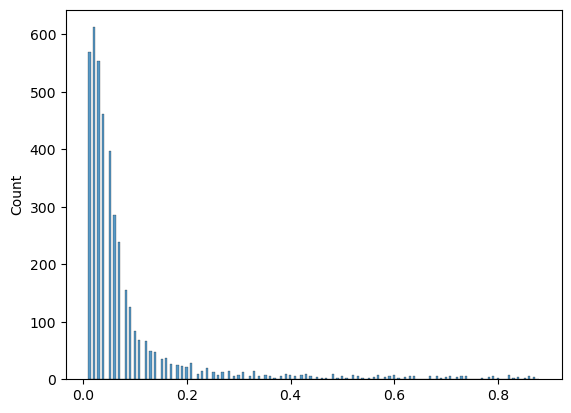

In [8]:
def predict_batch(X, knn_model):
    return knn_model.predict(X)

def predict_prob_batch(X, knn_model):
    return knn_model.predict_proba(X)

def knn_predict_par(X, knn_model, num_cores):
    X_batches = np.array_split(X, num_cores)
    with Parallel(n_jobs=num_cores, backend="threading") as parallel:
        results = parallel(delayed(predict_batch)(X_batch, knn_model) for X_batch in X_batches)
    return np.concatenate(results)

def knn_predict_prob_par(X, knn_model, num_cores):
    X_batches = np.array_split(X, num_cores)
    with Parallel(n_jobs=num_cores, backend="threading") as parallel:
        results = parallel(delayed(predict_prob_batch)(X_batch, knn_model) for X_batch in X_batches)
    return np.concatenate(results)

prob_pred = knn_predict_prob_par(c_query, knn, 72)
pred_label = knn_predict_par(c_query, knn, 72)
prob_pred_unknown = prob_pred[:, -1]
sns.histplot(data=prob_pred_unknown, bins=200)

In [9]:
unknown_cell = np.array([False]*c_query.shape[0])

In [10]:
f1= []
unknown = (prob_pred_unknown > 0.85)
f1.append(f1_score(unknown_cell, unknown, average='micro'))
i = np.argmax(f1)
final_f1 = {"init_model": o.init_model, "f1": f1[i], "thresh": 0.85}
print(final_f1)

result_dir = pj("result", "comparison", o.task, o.method, o.experiment, o.model, o.init_model)
utils.mkdirs(result_dir, remove_old=False)
utils.save_toml(final_f1, pj(result_dir, "final_f1.toml"))

{'init_model': '', 'f1': 0.9976673664567296, 'thresh': 0.85}


In [11]:
result_dir = pj("result", "comparison", o.task, o.method, o.experiment, o.model, o.init_model)
utils.mkdirs(result_dir, remove_old=False)
label_pred = knn.classes_[np.argmax(prob_pred[:, :-1], axis = 1)]
label_pred[prob_pred_unknown > 0.85] = "Unknown" # confusion

utils.save_list_to_csv([list(line) for line in list(label_pred.reshape(-1, 1))], pj(result_dir, "label_transferred.csv"))
utils.save_list_to_csv([list(line) for line in list(label_gt_l1.reshape(-1, 1))], pj(result_dir, "label_gt.csv"))